# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

The goal of this project is to provide investment idea and recommendations to the investors, who are interested in investing in real estate in the city of Boston, MA, a tight real estate market due to these information "The Boston region’s population has been steadily swelling for around a decade, and as of late 2019 stands at nearly 4.9 million, give or take and depending on how you draw the regional boundaries. Blame/credit a strong local economy, immigration, and the area’s overall desirability. A corollary to this is that, because demand is so strong and prices so high, generations tend to pass down housing in the Boston area more than in some other places. Houses therefore spend several decades or more essentially off the market.The Boston area’s inventory of available homes has long failed to keep pace with this high demand. Despite a brisk pace of construction—particularly in Boston proper, where thousands of new condos have come online during the past decade—the need for housing continues to outstrip the supply.".
We will recommend, based on our analysis and modeling of historical data on real estate prices, obtained from the Zillow
Research Page (https://www.zillow.com/research/data/), if investing in Boston will be good for our stakeholders.

In [1]:
#Importing the library to use in this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [2]:
#Loading the Data
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#Renaming RegionName as Zipcode
df.rename({'RegionName': 'Zipcode'}, axis='columns', inplace=True)
df.head()
    

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
#filtering only data for Boston 
BOS = df.loc[df['City'] == 'Boston']


In [5]:
BOS.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
561,58649,2135,Boston,MA,Boston,Suffolk,562,165200.0,166200.0,167300.0,...,691300,699100,701200,703100,709100,717500,722600,728500,735400,738000
1169,58638,2124,Boston,MA,Boston,Suffolk,1170,100900.0,102000.0,103200.0,...,479500,486400,491800,496400,502400,509800,516000,523000,534100,543900
1511,58641,2127,Boston,MA,Boston,Suffolk,1512,124600.0,125000.0,125500.0,...,719400,724500,731000,739000,748800,759100,764900,776600,795000,807900
1670,58644,2130,Boston,MA,Boston,Suffolk,1671,185900.0,188000.0,190200.0,...,811400,817900,828000,839900,849100,853800,857600,866700,882600,892300
1921,58642,2128,Boston,MA,Boston,Suffolk,1922,83300.0,84500.0,85600.0,...,450100,457300,461200,464000,466300,467400,467200,471400,481400,489900


In [6]:
# checking total number of zip codes for Boston
print(f'We have {BOS.Zipcode.nunique()} different zip codes in our dataset for Boston.')

We have 22 different zip codes in our dataset for Boston.


We have a total of 22 zipcodes to use for our time series analysis. 
Our next step will be to use a function to transform our data from a wide format as it is now to a long format, and then make it into a pandas series of datetime object. We were provided with this helper function from our curriculum.

# Step 2: Data Preprocessing

In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State','Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [11]:
def melt_df(df):
    merged = []
    for zipcode in df.Zipcode:
        melted = melt_data(df.loc[df['Zipcode'] == zipcode])
        row = df.loc[df['Zipcode'] == zipcode].iloc[:,:7]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1) 
        merged.append(merge)
        melted_df = pd.concat(merged)
    return melted_df

In [12]:
BOS_melted = melt_df(BOS)
BOS_melted.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,time,value
0,58649,2135,Boston,MA,Boston,Suffolk,562,1996-04-01,165200.0
1,58649,2135,Boston,MA,Boston,Suffolk,562,1996-05-01,166200.0
2,58649,2135,Boston,MA,Boston,Suffolk,562,1996-06-01,167300.0
3,58649,2135,Boston,MA,Boston,Suffolk,562,1996-07-01,168400.0
4,58649,2135,Boston,MA,Boston,Suffolk,562,1996-08-01,169500.0


In [13]:
BOS_melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5407 entries, 0 to 264
Data columns (total 9 columns):
RegionID      5407 non-null int64
Zipcode       5407 non-null int64
City          5407 non-null object
State         5407 non-null object
Metro         5407 non-null object
CountyName    5407 non-null object
SizeRank      5407 non-null int64
time          5407 non-null datetime64[ns]
value         5407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 422.4+ KB


In [15]:
#We will set the time column as index for Boston a
BOS_melted.set_index('time', inplace=True)
BOS_melted.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-05-01,58649,2135,Boston,MA,Boston,Suffolk,562,166200.0
1996-06-01,58649,2135,Boston,MA,Boston,Suffolk,562,167300.0
1996-07-01,58649,2135,Boston,MA,Boston,Suffolk,562,168400.0
1996-08-01,58649,2135,Boston,MA,Boston,Suffolk,562,169500.0
1996-09-01,58649,2135,Boston,MA,Boston,Suffolk,562,170600.0


#### Step 3: EDA and Visualization

In [16]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


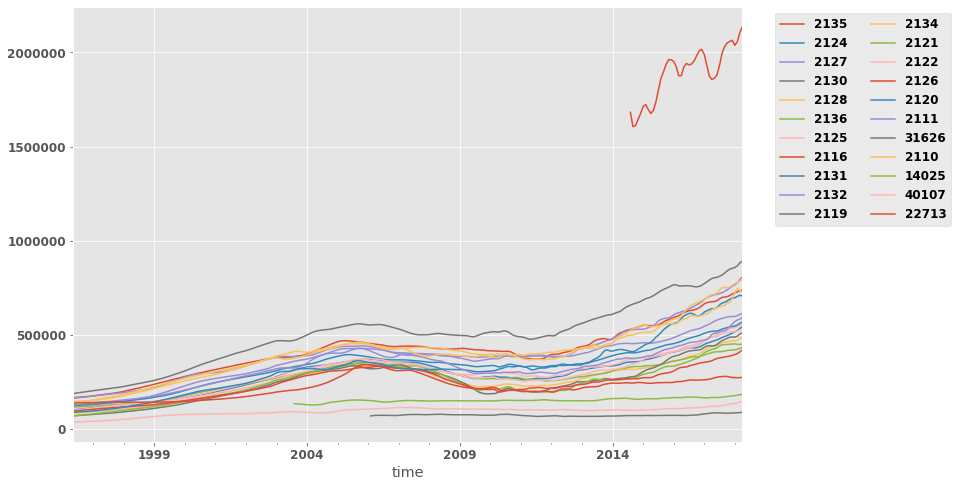

In [17]:
plt.figure(figsize=(12,8))
for zipcode in BOS_melted.Zipcode.unique():
    BOS_melted.loc[BOS_melted['Zipcode'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show()

# Step 5: ARIMA Modeling

We will make a simulation on one zipcode and will move from there to generalize to all the other zipcodes. We will use the first zipcode displayed when we have applied head(), 2135. 

In [18]:
sim = BOS_melted.loc[BOS_melted['Zipcode'] == 2135]

Dep. Variable:,value,No. Observations:,264
Model:,"SARIMAX(0, 1, 1)x(0, 1, 1, 12)",Log Likelihood,-2166.446
Date:,"Sun, 02 Feb 2020",AIC,4338.892
Time:,15:35:50,BIC,4349.296
Sample:,05-01-1996,HQIC,4343.085
,- 04-01-2018,,
Covariance Type:,opg,,


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,0.8298,0.032,25.961,0.000,0.767,0.892
ma.S.L12,-0.2655,0.036,-7.299,0.000,-0.337,-0.194
sigma2,4.492e+06,3.04e+05,14.784,0.000,3.9e+06,5.09e+06


Ljung-Box (Q):,290.09,Jarque-Bera (JB):,36.37
Prob(Q):,0.00,Prob(JB):,0.00
Heteroskedasticity (H):,4.48,Skew:,0.41
Prob(H) (two-sided):,0.00,Kurtosis:,4.74


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


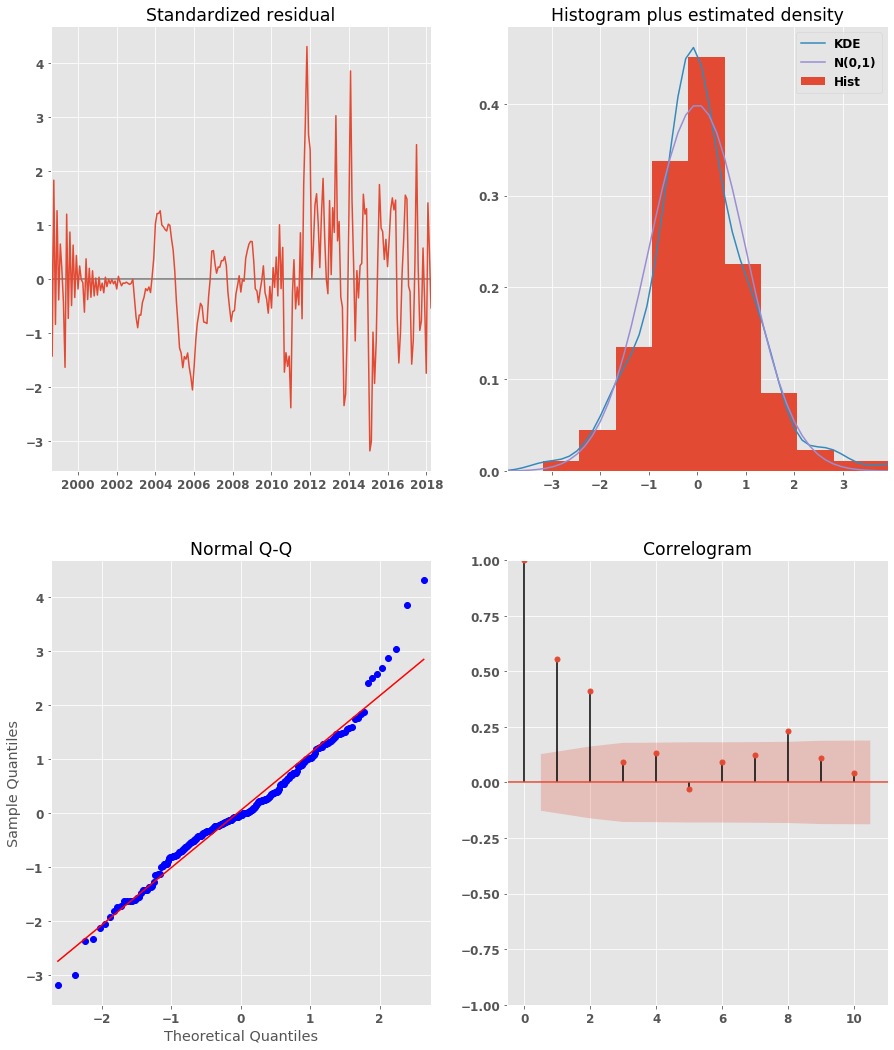

In [19]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(sim.value,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
display(output.summary().tables[0], output.summary().tables[1], output.summary().tables[2])

output.plot_diagnostics(figsize=(15, 18))
plt.show()

Let us see if we can make some prediction for zipcode 2135.

In [32]:
pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [33]:
b = {}
b['a'] = pred_conf[pred_conf.index == '2016-02-01']['lower value'][0]

In [34]:
pred_conf[pred_conf.index == '2016-02-01']['lower value']

2016-02-01    591780.628074
Freq: MS, Name: lower value, dtype: float64

In [35]:
b

{'a': 591780.6280743263}

In [36]:
pred_conf['upper value'].mean()

670173.5556086862

In [37]:
pred.predicted_mean['2018-01-01']

726300.3108818318

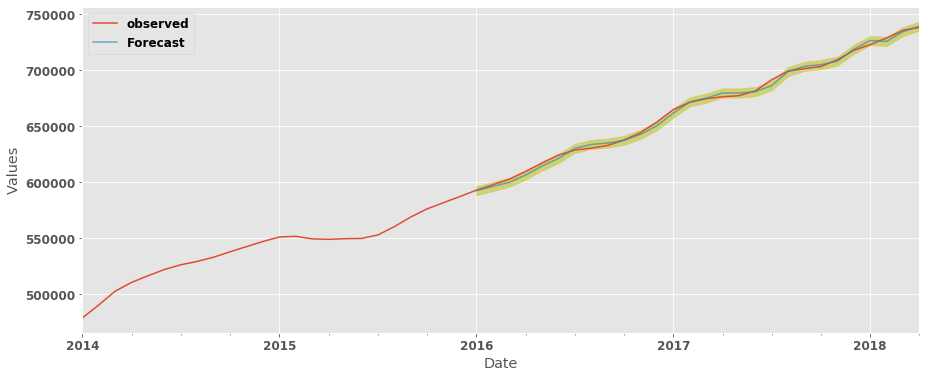

In [39]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = sim['2014':].value.plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

plt.show()


In [40]:
sim_forecasted = pred.predicted_mean
sim_truth = sim['2017':].value
sim_forecasted = sim_forecasted['2017':]
# Compute the root mean square error
error = mean_squared_error(sim_forecasted, sim_truth)
error = np.sqrt(error)
print(f'The RMSE of our forecasts is {error}')

The RMSE of our forecasts is 2369.35897092424


Our predictions are within about 2,400 dollars. Meaning about give or take 1,200 dollars. This appears to be very good given the high house prices in Boston.

For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using statsmodels library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [41]:
# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [42]:
best_combs_BOS = []
for zipcode in BOS_melted.Zipcode.unique():
    ans_BOS = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(BOS_melted.loc[BOS_melted['Zipcode'] == zipcode].value,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                out_BOS = mod.fit()
                ans_BOS.append([zipcode, comb, combs, out_BOS.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, out_BOS.aic))
            except:
                continue
    best_combs_BOS.append(sorted(ans_BOS, key=lambda x: x[3])[0])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7575.3894378014065
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7077.807470128314
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6022.939042245711
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5744.354522196163
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5910.801828984552
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5854.043336210445
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5565.268356538843
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7368.243068775988
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7356.561997106901
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7357.47682701068
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6042.332915391427
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =8213.743174868974
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7490.39569264397
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6959.661091958031
ARIMA (0, 0, 1) x (1,

ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4051.8967237220795
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4042.5497183046264
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4230.595958692269
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4006.8964035911313
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4242.778150447467
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3933.327693690633
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4028.3300543041714
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4009.166801079965
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3990.5982703960804
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3916.3154947446524
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7554.417299509003
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =210848.94031482755
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6060.451703688748
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5782.543750176501
ARIMA (0, 0, 

ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4972.849576880082
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4760.21275401646
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4596.001728949224
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4707.873841727988
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4521.940546725591
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4981.212112558314
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4643.0901854530275
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4435.629747952853
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4603.424256052123
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4369.150319111084
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4440.3895064771295
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4436.108087202689
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4357.235048164618
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4359.519434483544
ARIMA (1, 1, 1) x (

ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4504.222751055368
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4531.418209051462
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4330.314076307112
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4479.833014590153
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4481.21661563292
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4291.702102526643
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4293.249625947587
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4519.817313527183
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4383.593129390229
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4423.166179859801
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4056.2851809731064
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4336.3910270687375
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4305.748009184006
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4100.8153672061835
ARIMA (1, 0, 1) x 

ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =472.0658791371929
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1044.7341151498836
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =20632.366098526658
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =778.400981316597
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =757.4979859623606
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =18172.687979916744
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =482.83022080885365
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =994.9557864030119
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =11080.21083932827
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =765.1091534226186
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =734.4663202204381
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =9588.583203198294
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =472.06003303770166
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =995.6627974771144
ARIMA (1, 1, 0) 

ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4526.548142041023
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4360.197642570576
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4305.962950831223
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4168.1131667121335
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4860.550722445861
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4698.295654719044
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4739.283363446586
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4528.301092353346
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4633.159882456008
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4700.30552176525
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4470.7123207401055
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4467.682383006502
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4534.8184584331175
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4501.632311892981
ARIMA (1, 0, 1) x 

ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4936.657398373188
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4644.513992292563
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4893.505320719907
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4864.9858794036445
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4636.5653134161
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4616.648875150961
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4837.970750755378
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4600.987627298342
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4768.681988384782
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4472.97934484598
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4660.800399258658
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4602.97031793098
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4527.270662931593
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4412.630353015769
ARIMA (1, 0, 0) x (0, 0

ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6814.794696658156
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5726.637104383721
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7771.044844565833
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6850.341965066027
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6797.847182174451
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =5535.850065272566
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =6925.042132368408
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4953.849439603404
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4700.517254222598
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4727.8642050094195
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4470.226302235823
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4684.298400853465
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4662.654545928883
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4466.026910306934
ARIMA (0, 1, 0) x (

ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4106.672590958851
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4039.9003344651223
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7474.0259552569205
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6981.7302947211765
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6074.6730016458205
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5747.511516089098
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5939.448217412947
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5907.089702817855
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5695.265796005199
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7247.3995340227375
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7254.974686658449
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6880.708460212501
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6064.3378539827
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5575.411531351653
ARIMA (0, 0, 1) x

ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4319.5014641284415
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4441.213076974039
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4443.333658264966
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4318.15082408171
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4318.485446766145
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4600.356319761511
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4378.099535764328
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4489.851578587755
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4243.163272609314
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4400.991457035034
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4379.743340083919
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4266.866839366958
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4238.561043629327
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =3690.9280246156577
ARIMA (0, 0, 0) x (

ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4722.960531412893
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4910.672943856698
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4624.154261655053
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4742.0054662432085
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4814.671445466144
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4618.336630270665
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4964.326947415733
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4989.702243014247
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4769.242538116929
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4882.709496943904
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4634.056590362752
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4773.258818523728
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4769.174314757311
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4632.019397533854
ARIMA (1, 1, 0) x (

ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3780.926327557424
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3714.8464723898046
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4302.435937682798
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4112.18230507713
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4194.130688871749
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4010.2940732844127
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4109.730427428886
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4107.5489821464635
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =3955.3901471984072
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =3956.6909790829523
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4094.258103914445
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =3911.784347163877
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4027.9157065462878
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3797.3672696735784
ARIMA (1, 0, 1

In [43]:
best_combs_BOS 

[[2135, (1, 1, 1), (1, 1, 1, 12), 4181.6127834168165],
 [2124, (1, 1, 1), (1, 1, 1, 12), 3916.3154947446524],
 [2127, (1, 1, 1), (1, 1, 1, 12), 4209.021448068187],
 [2130, (1, 1, 1), (1, 1, 1, 12), 4268.22531407041],
 [2128, (1, 1, 1), (1, 1, 1, 12), 3944.373223772615],
 [2136, (1, 1, 1), (0, 1, 1, 12), 3843.9959131733995],
 [2125, (1, 1, 1), (1, 1, 1, 12), 4021.082864521065],
 [2116, (1, 1, 0), (1, 1, 0, 12), 448.63479440360544],
 [2131, (1, 1, 1), (0, 1, 1, 12), 3991.401244234452],
 [2132, (1, 1, 1), (0, 1, 1, 12), 3957.989616966873],
 [2119, (1, 1, 1), (1, 1, 1, 12), 4162.354076476486],
 [2134, (1, 1, 1), (1, 1, 1, 12), 4333.6947861327135],
 [2121, (1, 1, 1), (1, 1, 1, 12), 4071.135924541658],
 [2122, (1, 1, 1), (0, 1, 1, 12), 4089.615077532986],
 [2126, (1, 1, 1), (1, 1, 1, 12), 4039.9003344651223],
 [2120, (1, 1, 1), (1, 1, 1, 12), 4453.305688277258],
 [2111, (1, 1, 1), (1, 1, 1, 12), 4238.561043629327],
 [31626, (1, 1, 1), (0, 1, 1, 12), 1885.8040875062616],
 [2110, (1, 1, 1), (0

After running the model initially with all the best combination, there was an error message, zip code 02116 didn't have enough data. we will get of this zip code in our analysis

In [72]:
best_combs_BOS  = [[2135, (1, 1, 1), (1, 1, 1, 12), 4181.6127834168165],
[2124, (1, 1, 1), (1, 1, 1, 12), 3916.3154947446524],
 [2127, (1, 1, 1), (1, 1, 1, 12), 4209.021448068187],
 [2130, (1, 1, 1), (1, 1, 1, 12), 4268.22531407041],
 [2128, (1, 1, 1), (1, 1, 1, 12), 3944.373223772615],
 [2136, (1, 1, 1), (0, 1, 1, 12), 3843.9959131733995],
 [2125, (1, 1, 1), (1, 1, 1, 12), 4021.082864521065],
 
 [2131, (1, 1, 1), (0, 1, 1, 12), 3991.401244234452],
 [2132, (1, 1, 1), (0, 1, 1, 12), 3957.989616966873],
 [2119, (1, 1, 1), (1, 1, 1, 12), 4162.354076476486],
 [2134, (1, 1, 1), (1, 1, 1, 12), 4333.6947861327135],
 [2121, (1, 1, 1), (1, 1, 1, 12), 4071.135924541658],
 [2122, (1, 1, 1), (0, 1, 1, 12), 4089.615077532986],
 [2126, (1, 1, 1), (1, 1, 1, 12), 4039.9003344651223],
 [2120, (1, 1, 1), (1, 1, 1, 12), 4453.305688277258],
 [2111, (1, 1, 1), (1, 1, 1, 12), 4238.561043629327],]

In [64]:
def make_pred_image(df, sim_forecasted, forecast, zipcode=None):
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = df['2014':].plot(label='observed')

    #Plot predicted values
    sim_forecasted['2014-01-01':].plot(ax=ax, label='Predicted', alpha=.7)
    
    forecast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.legend()

    plt.show()
    return None

2135
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7053      0.036     19.340      0.000       0.634       0.777
ma.L1          0.7389      0.030     24.417      0.000       0.680       0.798
ar.S.L12       0.1534      0.047      3.236      0.001       0.060       0.246
ma.S.L12      -0.4604      0.033    -14.145      0.000      -0.524      -0.397
sigma2      2.338e+06   1.46e+05     15.992      0.000    2.05e+06    2.63e+06


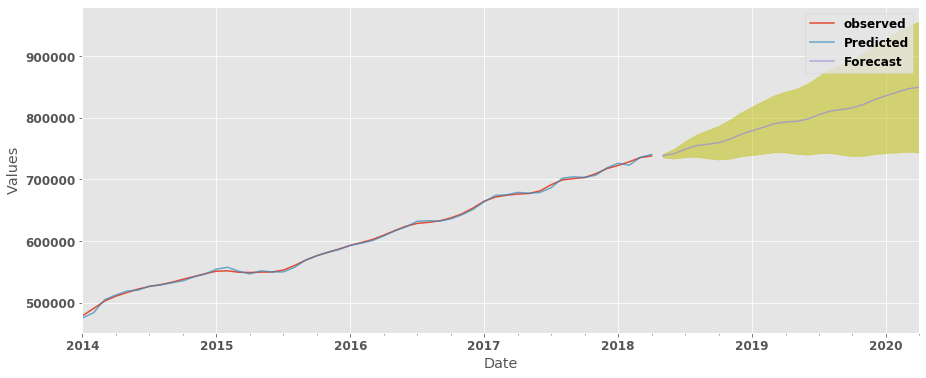

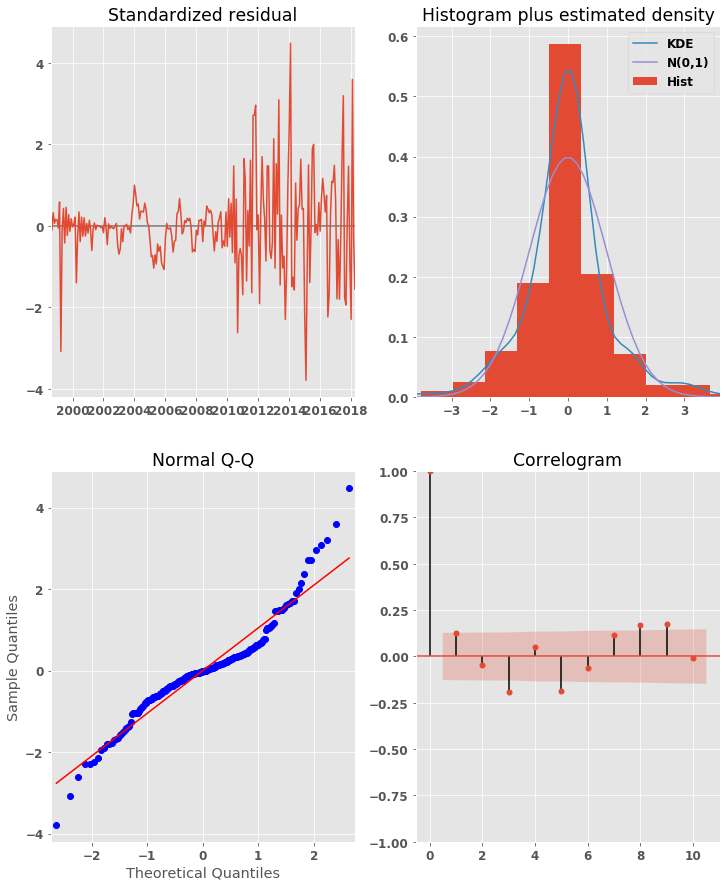

2124
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8345      0.030     28.151      0.000       0.776       0.893
ma.L1          0.7260      0.036     20.100      0.000       0.655       0.797
ar.S.L12       0.1067      0.068      1.569      0.117      -0.027       0.240
ma.S.L12      -0.6453      0.050    -12.883      0.000      -0.743      -0.547
sigma2      7.248e+05   4.49e+04     16.135      0.000    6.37e+05    8.13e+05


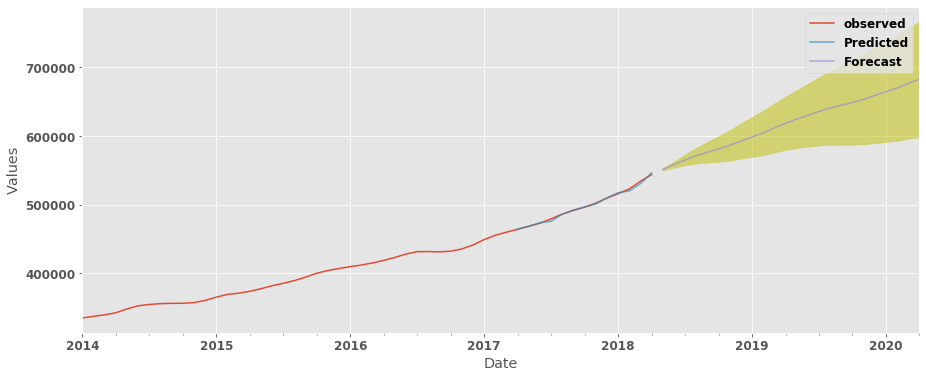

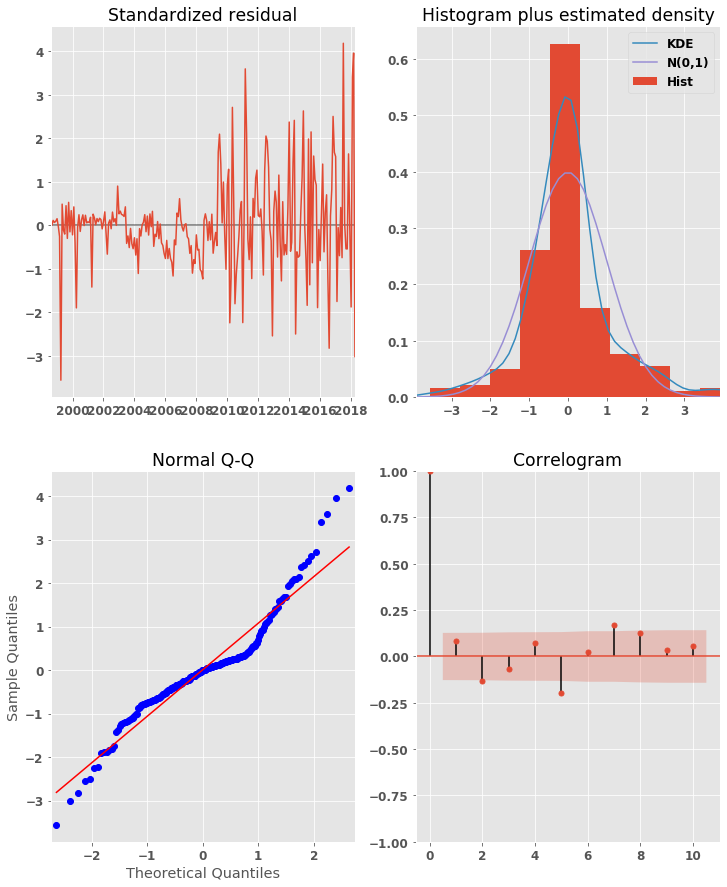

2127
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5801      0.042     13.968      0.000       0.499       0.661
ma.L1          0.6336      0.036     17.377      0.000       0.562       0.705
ar.S.L12       0.2195      0.077      2.855      0.004       0.069       0.370
ma.S.L12      -0.5113      0.072     -7.080      0.000      -0.653      -0.370
sigma2      3.274e+06   2.02e+05     16.241      0.000    2.88e+06    3.67e+06


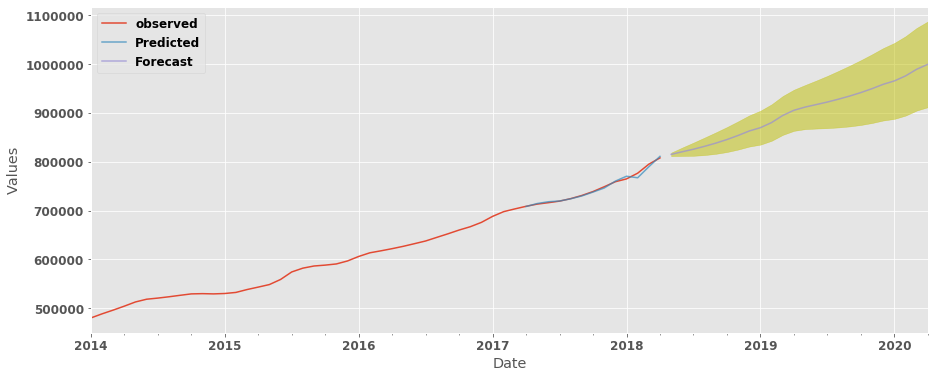

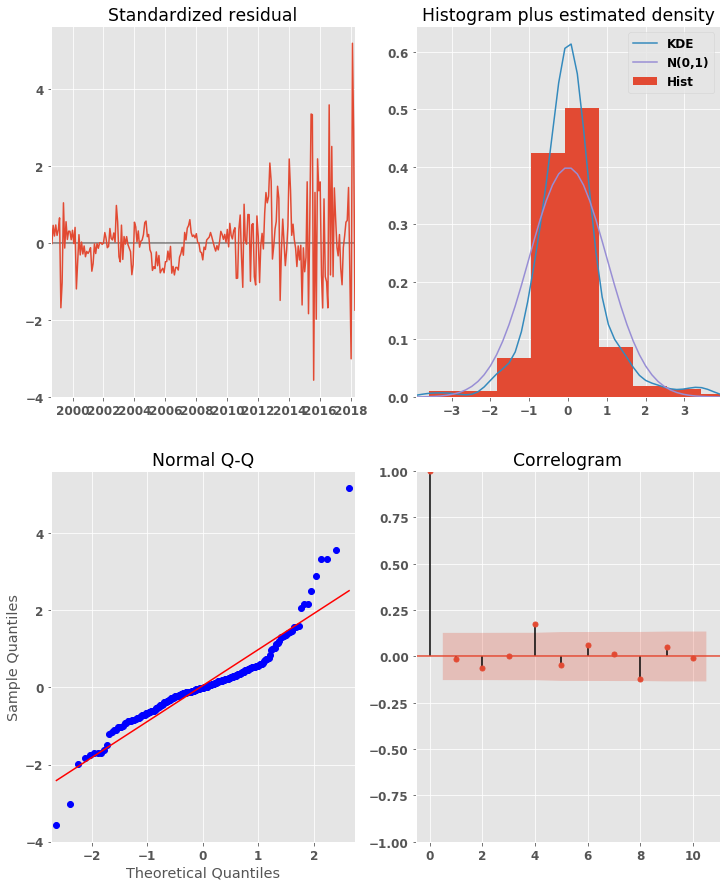

2130
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7135      0.038     18.824      0.000       0.639       0.788
ma.L1          0.6519      0.044     14.699      0.000       0.565       0.739
ar.S.L12       0.2388      0.073      3.284      0.001       0.096       0.381
ma.S.L12      -0.4633      0.060     -7.758      0.000      -0.580      -0.346
sigma2      3.946e+06   2.89e+05     13.663      0.000    3.38e+06    4.51e+06


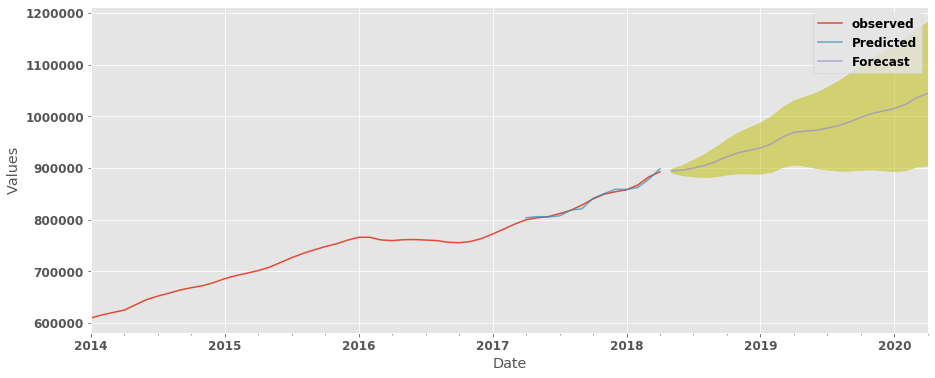

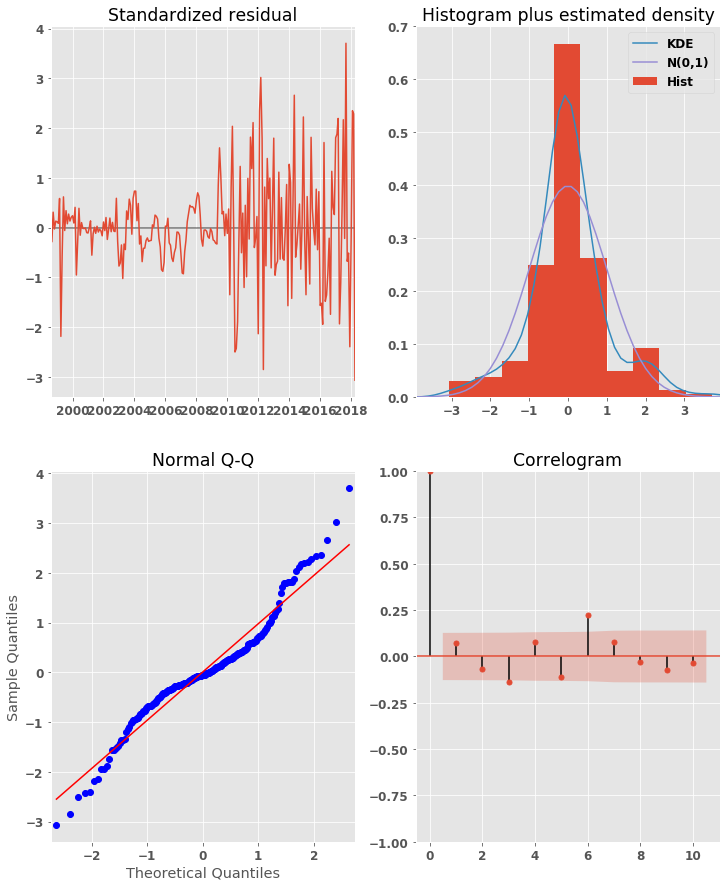

2128
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7736      0.041     18.979      0.000       0.694       0.853
ma.L1          0.7648      0.038     19.904      0.000       0.690       0.840
ar.S.L12       0.1075      0.048      2.221      0.026       0.013       0.202
ma.S.L12      -0.5675      0.046    -12.368      0.000      -0.657      -0.478
sigma2      1.078e+06   8.24e+04     13.078      0.000    9.17e+05    1.24e+06


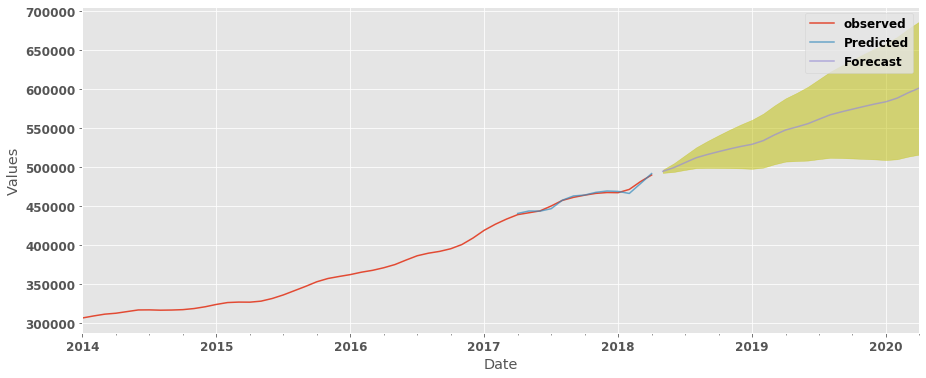

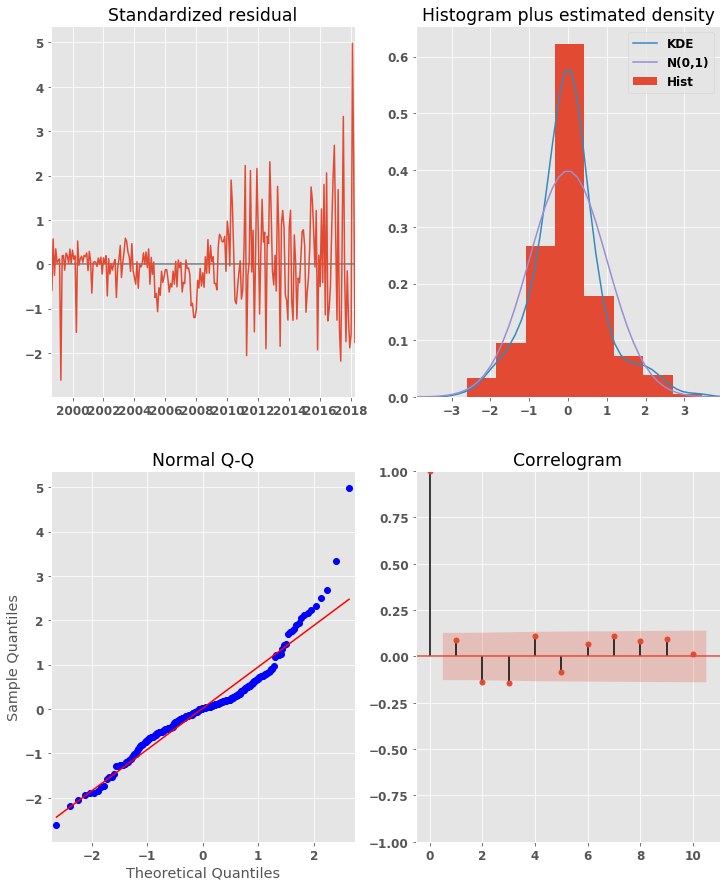

2136
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7716      0.036     21.366      0.000       0.701       0.842
ma.L1          0.6923      0.032     21.496      0.000       0.629       0.755
ma.S.L12      -0.4714      0.032    -14.574      0.000      -0.535      -0.408
sigma2      5.114e+05    3.8e+04     13.462      0.000    4.37e+05    5.86e+05


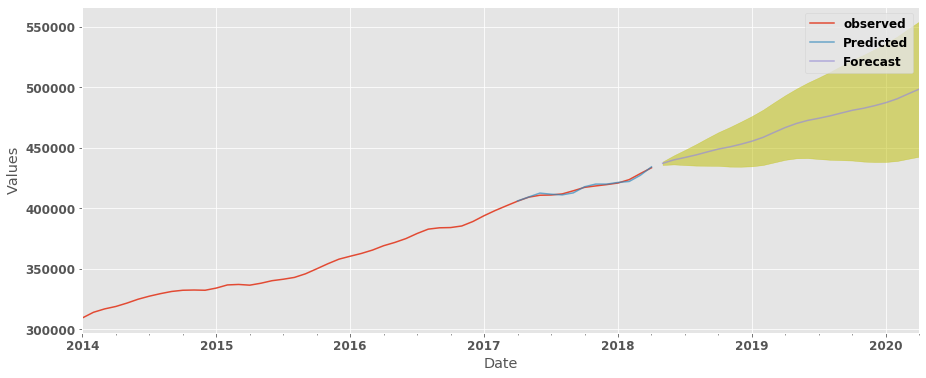

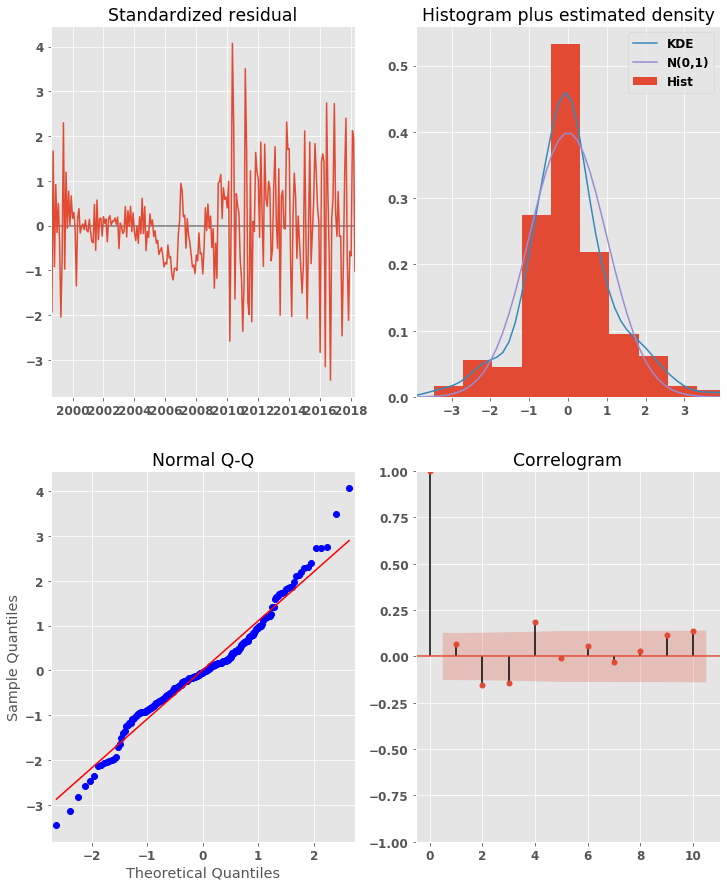

2125
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7222      0.039     18.288      0.000       0.645       0.800
ma.L1          0.6736      0.040     16.927      0.000       0.596       0.752
ar.S.L12       0.1538      0.069      2.227      0.026       0.018       0.289
ma.S.L12      -0.6424      0.053    -12.078      0.000      -0.747      -0.538
sigma2      1.164e+06   6.98e+04     16.683      0.000    1.03e+06     1.3e+06


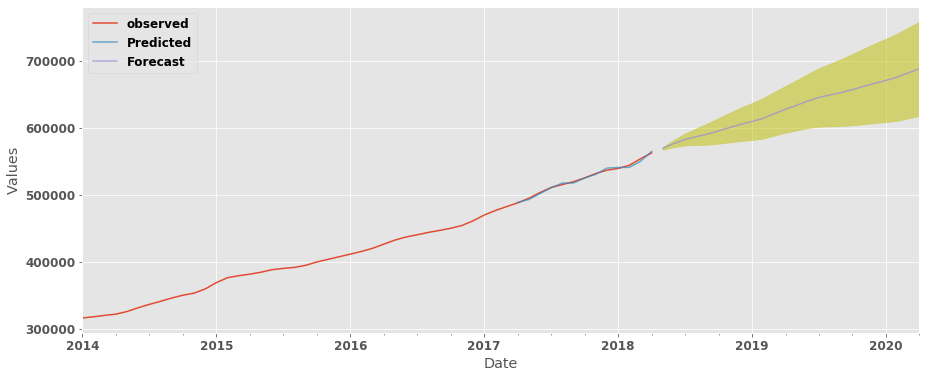

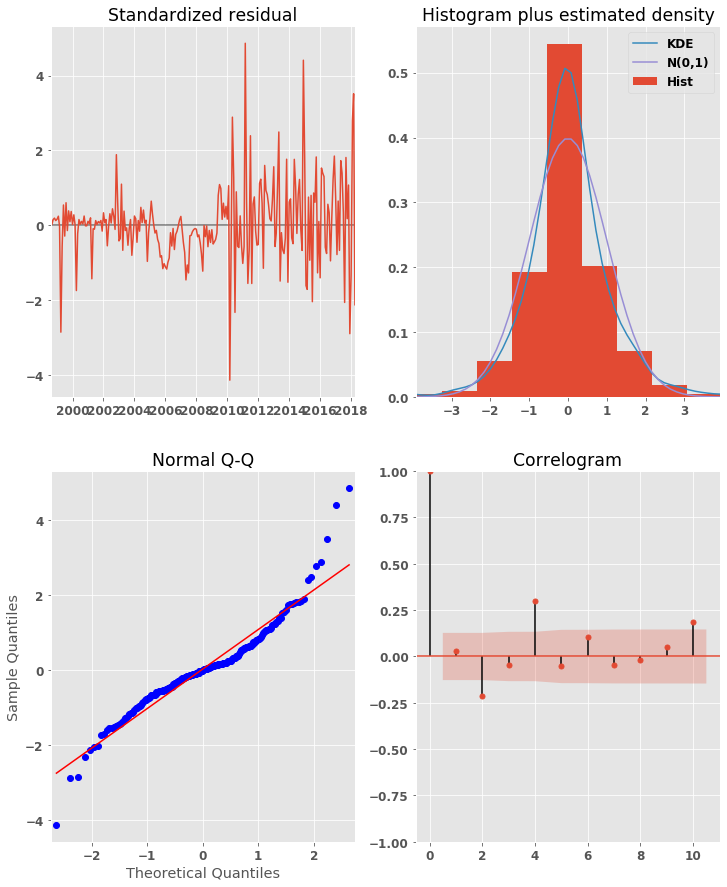

2131
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7056      0.042     16.808      0.000       0.623       0.788
ma.L1          0.6186      0.036     17.416      0.000       0.549       0.688
ma.S.L12      -0.3784      0.030    -12.792      0.000      -0.436      -0.320
sigma2      1.016e+06   6.74e+04     15.063      0.000    8.83e+05    1.15e+06


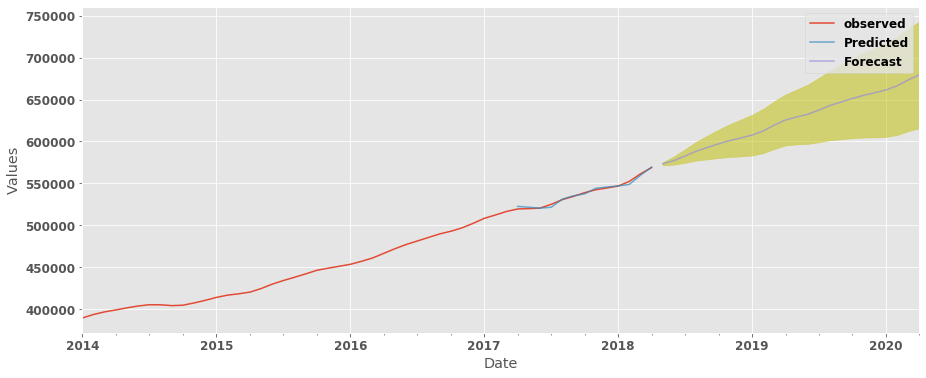

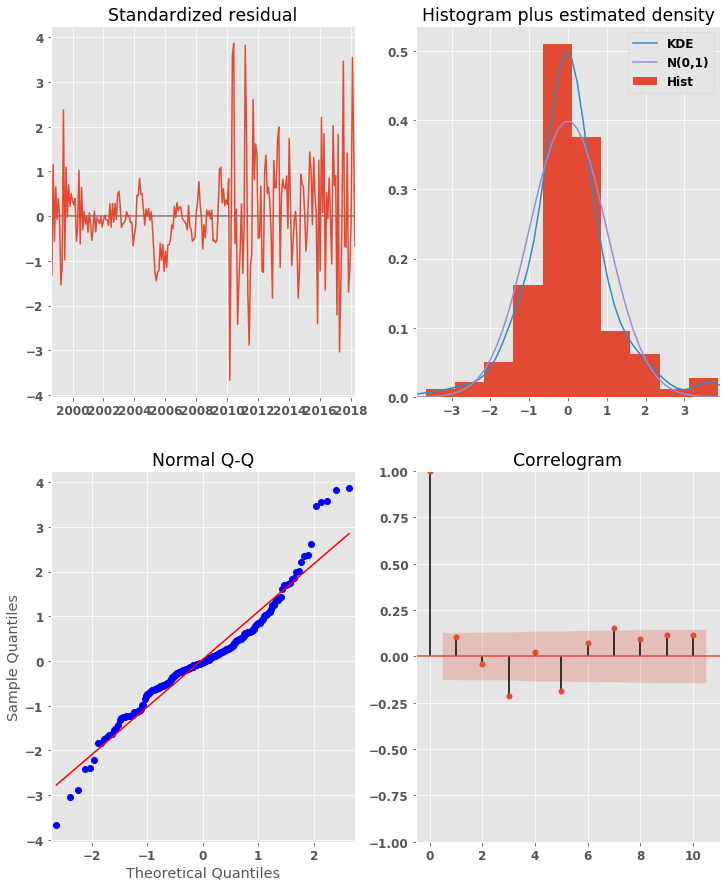

2132
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8146      0.031     26.194      0.000       0.754       0.876
ma.L1          0.7191      0.033     21.663      0.000       0.654       0.784
ma.S.L12      -0.2952      0.030    -10.002      0.000      -0.353      -0.237
sigma2      8.695e+05   6.09e+04     14.266      0.000     7.5e+05    9.89e+05


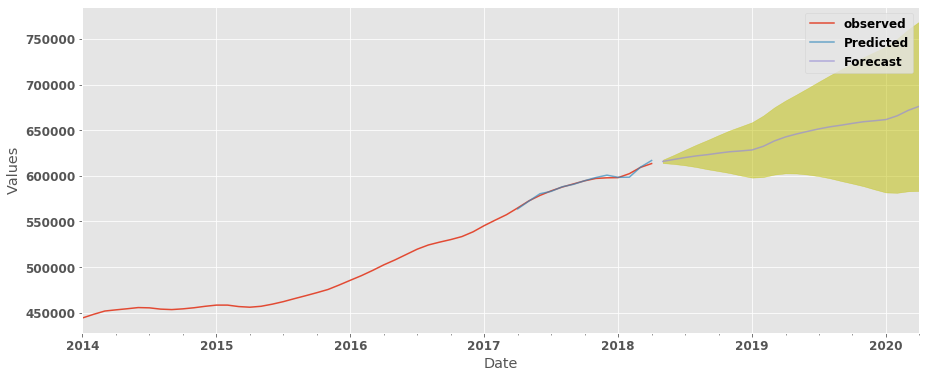

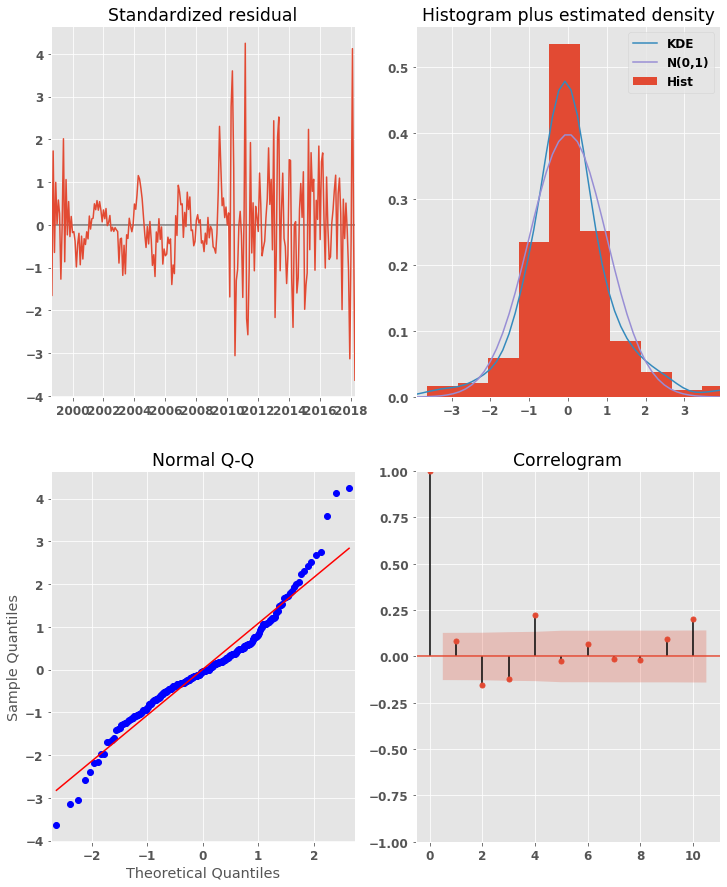

2119
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7375      0.035     21.038      0.000       0.669       0.806
ma.L1          0.8345      0.028     29.866      0.000       0.780       0.889
ar.S.L12       0.1257      0.040      3.126      0.002       0.047       0.204
ma.S.L12      -0.6866      0.030    -23.111      0.000      -0.745      -0.628
sigma2      1.995e+06   1.54e+05     12.991      0.000    1.69e+06     2.3e+06


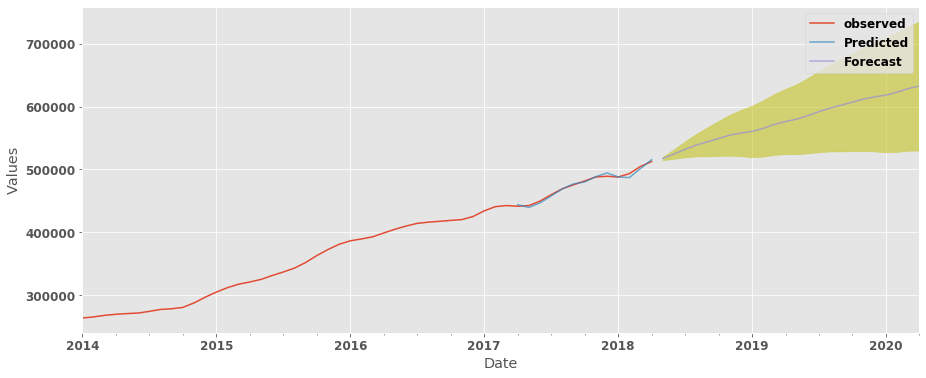

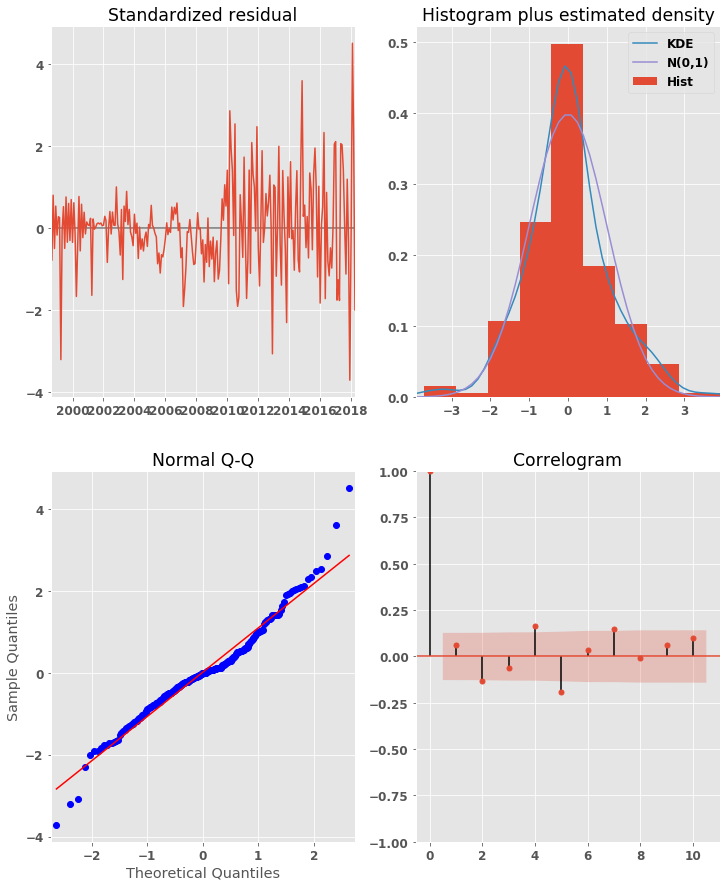

2134
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5938      0.048     12.259      0.000       0.499       0.689
ma.L1          0.7724      0.034     22.899      0.000       0.706       0.838
ar.S.L12       0.2175      0.054      4.049      0.000       0.112       0.323
ma.S.L12      -0.4720      0.046    -10.206      0.000      -0.563      -0.381
sigma2      5.495e+06   4.31e+05     12.754      0.000    4.65e+06    6.34e+06


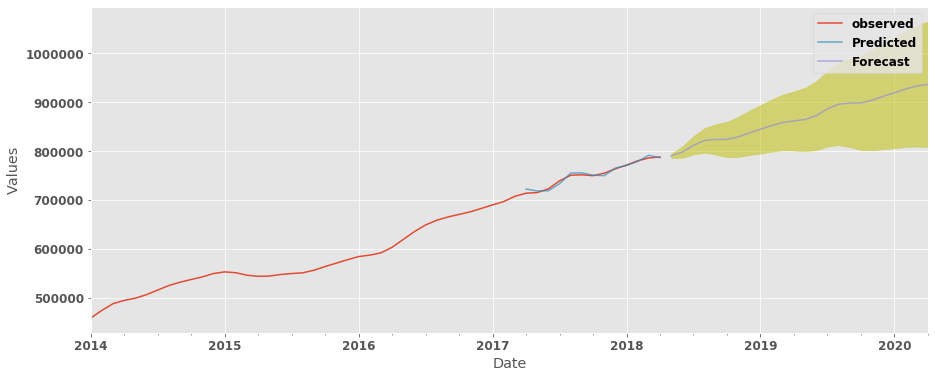

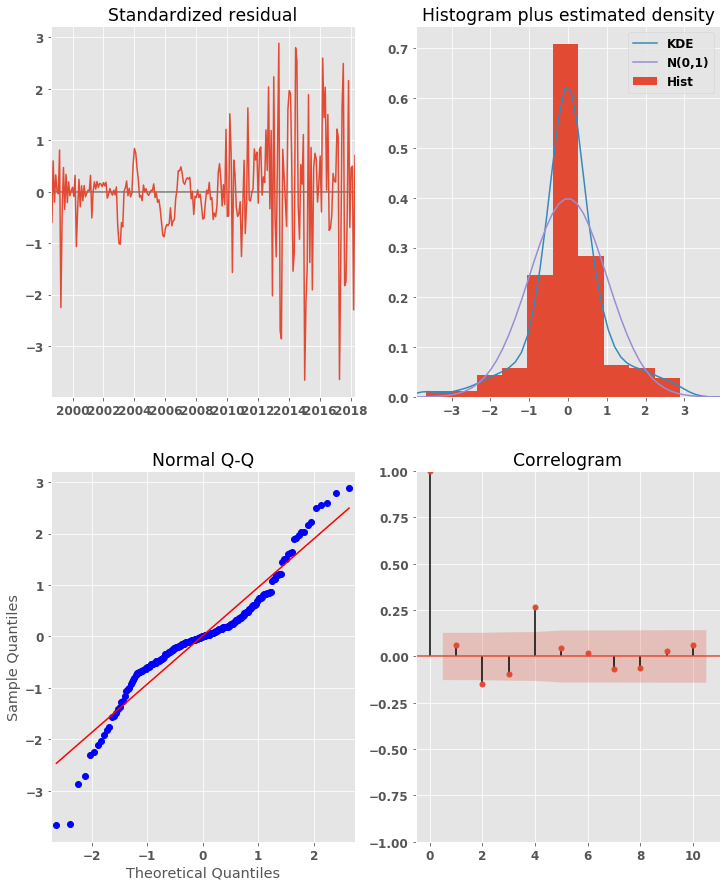

2121
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8071      0.032     25.428      0.000       0.745       0.869
ma.L1          0.8116      0.033     24.818      0.000       0.748       0.876
ar.S.L12       0.1223      0.048      2.549      0.011       0.028       0.216
ma.S.L12      -0.7089      0.034    -20.664      0.000      -0.776      -0.642
sigma2      1.377e+06   9.21e+04     14.953      0.000     1.2e+06    1.56e+06


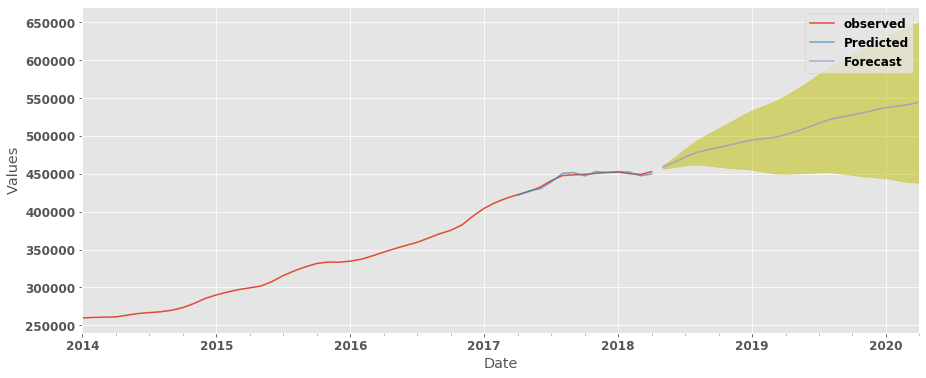

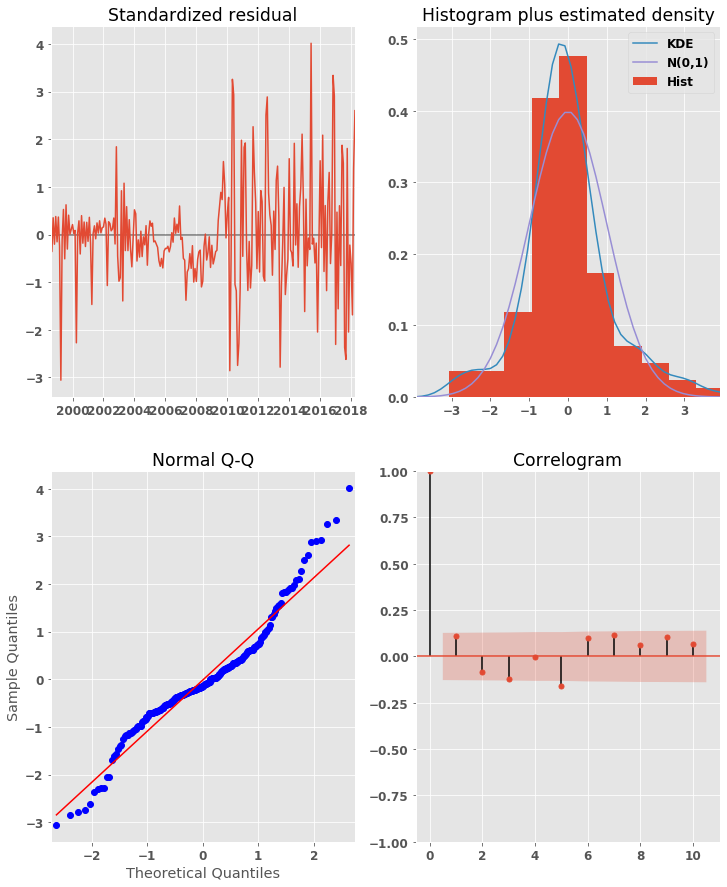

2122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6761      0.036     18.908      0.000       0.606       0.746
ma.L1          0.7161      0.032     22.197      0.000       0.653       0.779
ma.S.L12      -0.4407      0.030    -14.786      0.000      -0.499      -0.382
sigma2      1.501e+06   9.12e+04     16.468      0.000    1.32e+06    1.68e+06


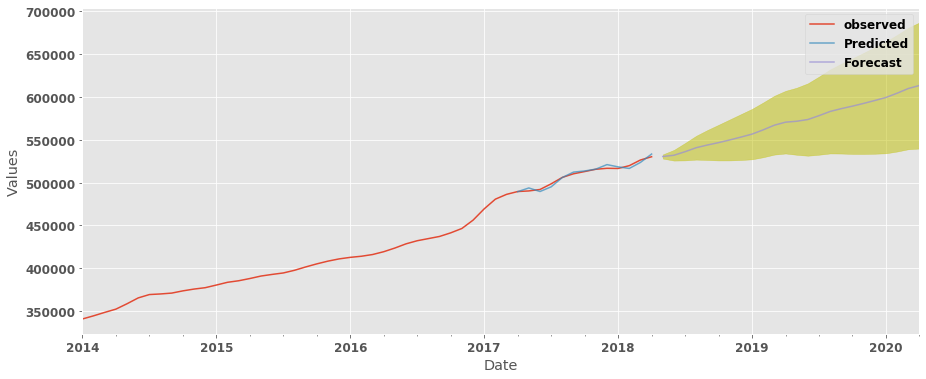

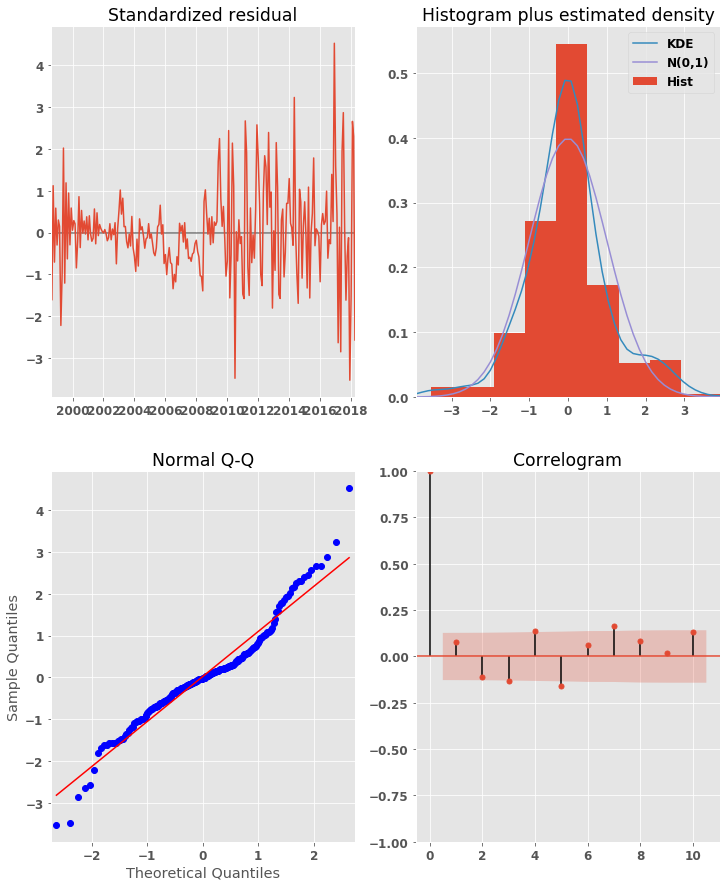

2126
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6516      0.050     13.145      0.000       0.554       0.749
ma.L1          0.8166      0.045     18.340      0.000       0.729       0.904
ar.S.L12       0.1126      0.043      2.640      0.008       0.029       0.196
ma.S.L12      -0.5341      0.033    -15.980      0.000      -0.600      -0.469
sigma2      1.707e+06   1.35e+05     12.670      0.000    1.44e+06    1.97e+06


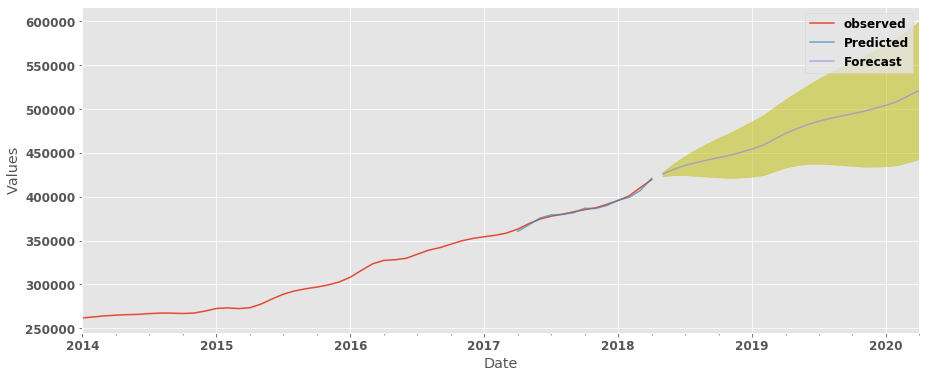

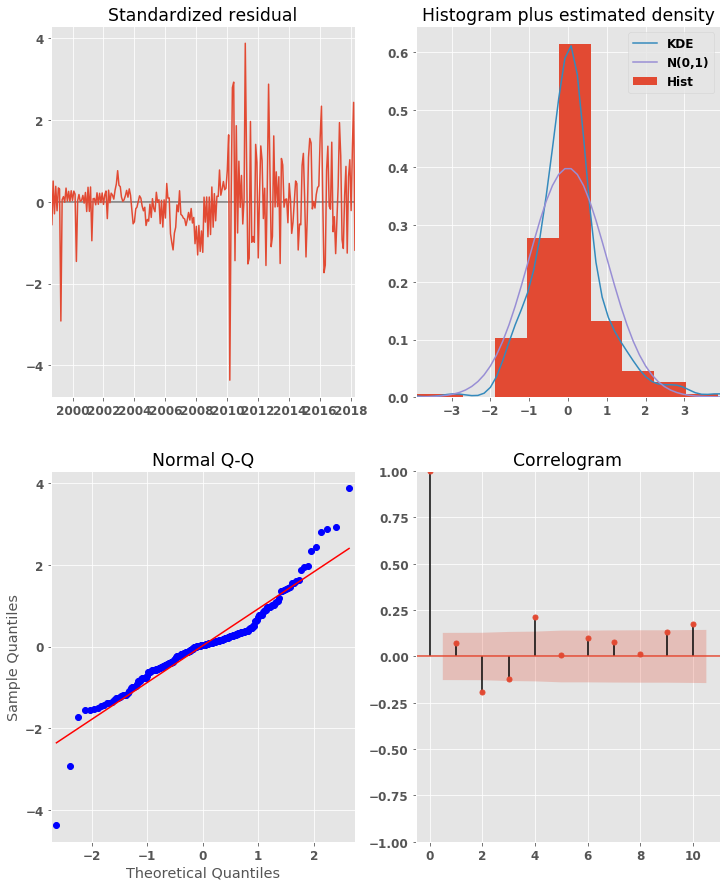

2120
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5395      0.057      9.400      0.000       0.427       0.652
ma.L1          0.5379      0.037     14.458      0.000       0.465       0.611
ar.S.L12      -0.4395      0.077     -5.686      0.000      -0.591      -0.288
ma.S.L12      -0.1277      0.074     -1.723      0.085      -0.273       0.018
sigma2      9.971e+06   8.14e+05     12.243      0.000    8.37e+06    1.16e+07


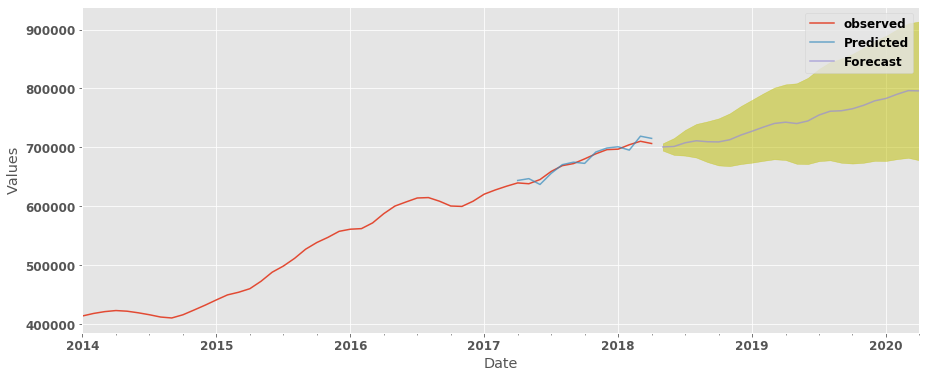

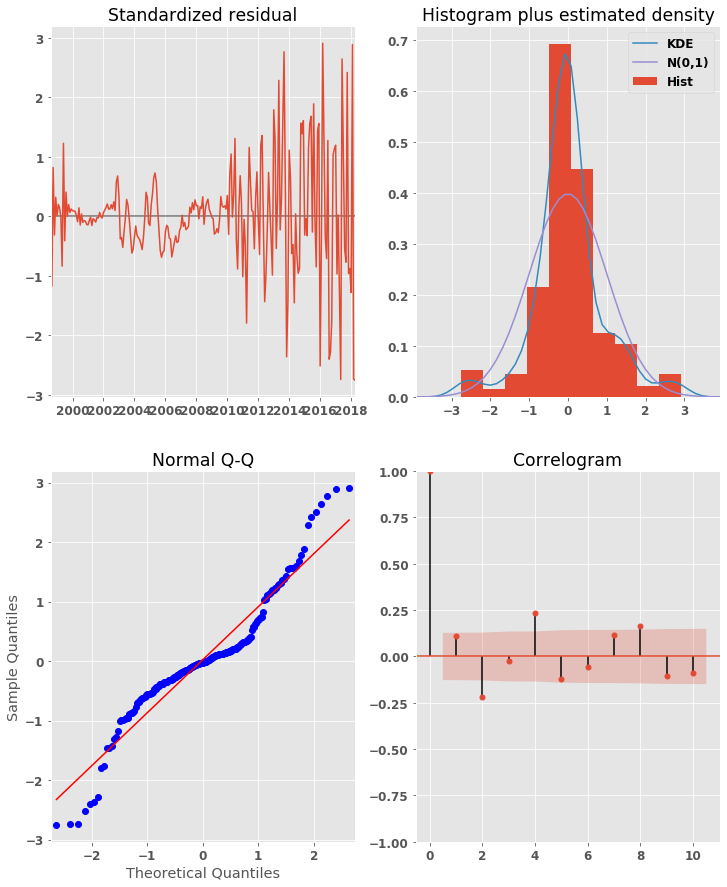

2111
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7020      0.033     21.375      0.000       0.638       0.766
ma.L1          0.6037      0.039     15.554      0.000       0.528       0.680
ar.S.L12       0.2653      0.149      1.786      0.074      -0.026       0.557
ma.S.L12      -0.4989      0.123     -4.057      0.000      -0.740      -0.258
sigma2      3.475e+06   1.91e+05     18.238      0.000     3.1e+06    3.85e+06


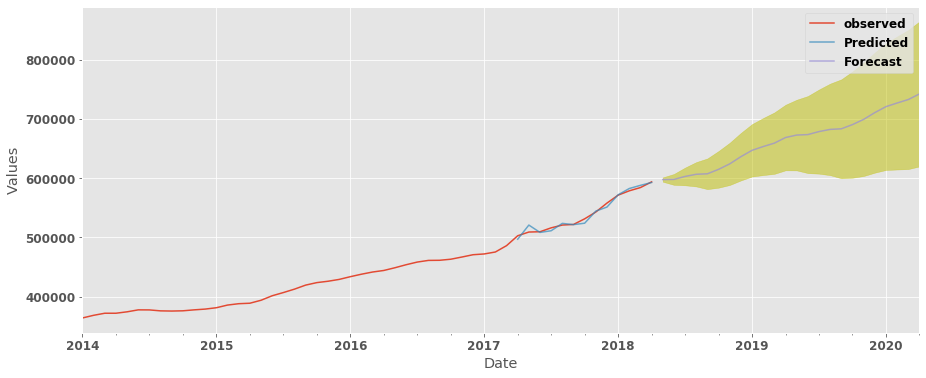

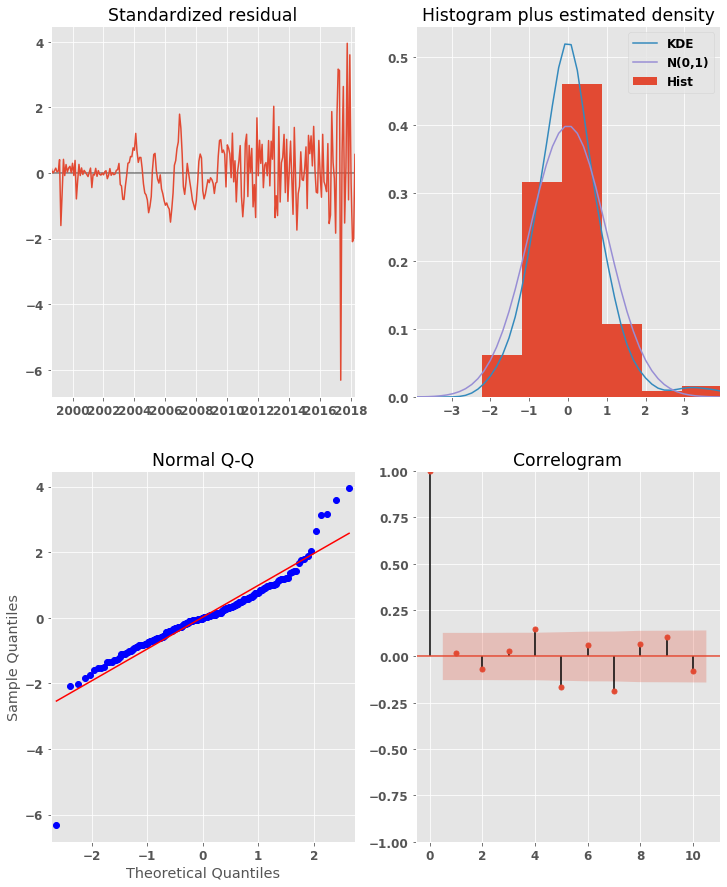

In [73]:
pred_df = pd.DataFrame()
known_RMSE = {}
forecast_2019_04 = {}
confid_min = {}
confid_max = {}
profit = {}
roi = {}
price_2018_04 = {}

for comb in best_combs_BOS:
    
    if comb[0] == 2135:
        
        df = BOS_melted.loc[BOS_melted['Zipcode'] == comb[0]].value.dropna()
        
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('2013-07-01'), dynamic=False)
        sim_forecasted = pred.predicted_mean
        sim_truth = sim['2013-07-01':].value
        sim_forecasted = sim_forecasted['2013-07-01':]
    else:
        
        df = BOS_melted.loc[BOS_melted['Zipcode'] == comb[0]].value.dropna()
       
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=False)
        sim_forecasted = pred.predicted_mean
        sim_truth = sim['2017-04-01':].value
        sim_forecasted = sim_forecasted['2017-04-01':]
    error = mean_squared_error(sim_forecasted, sim_truth)
    known_RMSE[comb[0]] = np.sqrt(error)
    forecast = output.get_forecast(steps=24)
    forecast_2019_04[comb[0]] = forecast.predicted_mean['2019-04-01']
    pred_conf = forecast.conf_int()
    confid_min[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['lower value'][0]
    confid_max[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['upper value'][0]
    val_04_18 = BOS_melted.loc[BOS_melted['Zipcode'] == comb[0]].value[-1]
    profit[comb[0]] = forecast.predicted_mean['2019-04'] - val_04_18
    roi[comb[0]] = profit[comb[0]]/val_04_18
    price_2018_04[comb[0]] = val_04_18
    
    print(comb[0])
    print(output.summary().tables[1])
    make_pred_image(df, sim_forecasted, forecast)
    output.plot_diagnostics(figsize=(12, 15))
    plt.show()
    
    

pred_df['zipcode'] = known_RMSE.keys()
pred_df['known_RMSE'] = known_RMSE.values()
pred_df['price_2018_04'] = price_2018_04.values()
pred_df['forecast_2019_04'] = forecast_2019_04.values()
pred_df['confid_min'] = confid_min.values()
pred_df['confid_max'] = confid_max.values()
pred_df['profit'] = profit.values()
pred_df['roi'] = roi.values()

The P>|z| provides the significance of each feature weight. For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model. Also, we have a lot of missing data in at least 7 of the zip codes in Boston. Our model end up working in 15 out 22 zip codes
For all the 15 zip codes we have these observations: In the top right plot of each zip code, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [74]:
pred_df['roi'] = pred_df['roi'].apply(lambda x: round(x[0], 2))

In [75]:
pred_df['profit'] = pred_df['profit'].apply(lambda x: round(x[0], 2))

In [76]:
pred_df['price_2018_04'] = pred_df['price_2018_04'].apply(lambda x: round(x))

In [77]:
pred_df['forecast_2019_04'] = pred_df['forecast_2019_04'].apply(lambda x: round(x))

In [78]:
pred_df['known_RMSE'] = pred_df['known_RMSE'].apply(lambda x: round(x, 2))

In [79]:
pred_df['confid_min'] = pred_df['confid_min'].apply(lambda x: round(x))

In [80]:
pred_df['confid_max'] = pred_df['confid_max'].apply(lambda x: round(x))

In [81]:
pred_df['max_loss'] = pred_df['price_2018_04'] - pred_df['confid_min']

In [82]:
pred_df['loi'] = (pred_df['price_2018_04'] - pred_df['confid_min'])/pred_df['price_2018_04']

In [83]:
pred_df.sort_values(by=['profit', 'roi'], ascending=False).head(10)

,zipcode,known_RMSE,price_2018_04,forecast_2019_04,confid_min,confid_max,profit,roi,max_loss,loi
2,2127,41668.71,807900,905363,863293,947433,97462.89,0.12,-55393,-0.068564
3,2130,133335.89,892300,968737,906357,1031117,76436.95,0.09,-14057,-0.015754
15,2111,165539.34,593600,668473,613137,723809,74873.23,0.13,-19537,-0.032913
1,2124,207447.11,543900,618571,579743,657400,74671.42,0.14,-35843,-0.065900
10,2134,47629.43,788000,861666,801095,922237,73665.76,0.09,-13095,-0.016618
6,2125,181562.69,562400,627595,592551,662640,65195.40,0.12,-30151,-0.053611
9,2119,230168.48,512600,576298,524204,628391,63697.67,0.12,-11604,-0.022638
4,2128,244650.50,489900,547700,507131,588269,57799.88,0.12,-17231,-0.035172
7,2131,167423.66,568900,625627,595181,656073,56727.01,0.10,-26281,-0.046196
0,2135,2410.43,738000,793039,743576,842502,55038.95,0.07,-5576,-0.007556


In [84]:
pred_df.sort_values(by=['roi', 'profit'], ascending=False).head(15)

,zipcode,known_RMSE,price_2018_04,forecast_2019_04,confid_min,confid_max,profit,roi,max_loss,loi
1,2124,207447.11,543900,618571,579743,657400,74671.42,0.14,-35843,-0.065900
15,2111,165539.34,593600,668473,613137,723809,74873.23,0.13,-19537,-0.032913
13,2126,319179.46,419400,472161,433184,511138,52760.80,0.13,-13784,-0.032866
2,2127,41668.71,807900,905363,863293,947433,97462.89,0.12,-55393,-0.068564
6,2125,181562.69,562400,627595,592551,662640,65195.40,0.12,-30151,-0.053611
9,2119,230168.48,512600,576298,524204,628391,63697.67,0.12,-11604,-0.022638
4,2128,244650.50,489900,547700,507131,588269,57799.88,0.12,-17231,-0.035172
11,2121,262346.84,452700,501676,450018,553334,48975.79,0.11,2682,0.005924
7,2131,167423.66,568900,625627,595181,656073,56727.01,0.10,-26281,-0.046196
3,2130,133335.89,892300,968737,906357,1031117,76436.95,0.09,-14057,-0.015754


# Step 6: Interpreting Results

The last part of our project is to choose the  best zipcodes where our stakeholder can invest in Boston

The return on investment in real estate in Boston appears to be really low. the 3 top zip codes with roi 13% and 14% are 2124, 2111 and 2126. Still, considering the fact that owning a house or even flipping house may involve some expenses, we may not recommend our stakeholder to invest in real estate in Boston.